In [2]:
#@title Package import {display-mode: "form"}

import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.naive_bayes import GaussianNB


from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

np.random.seed(1)

In [3]:
# Import libraries

import torch
import string
import re
import urllib
import nltk
from urllib.parse import urlparse

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from transformers import BertTokenizer, BertModel
import gensim.downloader as api

In [4]:
# Download required NLTK data

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:

#Set parameters to see all data
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

In [6]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [7]:
# Initialize the WordNet Lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [8]:
# Read dataset

%%time
data_path = 'train.tsv'

try:
    data = pd.read_csv(data_path, sep='\t')
except pd.errors.ParserError as e:
    print(f'Error while parsing CSV file: {e}')

data = data.replace('?', np.nan)
data = data.dropna()
data.shape

CPU times: user 251 ms, sys: 57.5 ms, total: 309 ms
Wall time: 318 ms


(3566, 27)

In [9]:
data[['alchemy_category', 'hasDomainLink', 'is_news', 'lengthyLinkDomain', 'news_front_page']].head(10)

,alchemy_category,hasDomainLink,is_news,lengthyLinkDomain,news_front_page
0,business,0,1,1,0
1,recreation,0,1,1,0
2,health,0,1,1,0
3,health,0,1,0,0
4,sports,0,1,1,0
6,arts_entertainment,0,1,0,0
10,business,0,1,1,0
12,health,0,1,1,0
16,recreation,0,1,0,0
17,arts_entertainment,0,1,0,0


In [10]:
data.iloc[:, :15].head()

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0,0.090774,0
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,0.0,0,0.098707,0
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,0.0,0,0.072448,0
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,0.480725,0.0,0,0.095861,0
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,0.446143,0.0,0,0.024908,0


In [11]:
data.iloc[:, 14:].head()

,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
0,0,0.245831,0.003883,1,1,24,0,5424,170,8,0.152941,0.079130,0
1,0,0.203490,0.088652,1,1,40,0,4973,187,9,0.181818,0.125448,1
2,0,0.226402,0.120536,1,1,55,0,2240,258,11,0.166667,0.057613,1
3,0,0.265656,0.035343,1,0,24,0,2737,120,5,0.041667,0.100858,1
4,0,0.228887,0.050473,1,1,14,0,12032,162,10,0.098765,0.082569,0


In [12]:
data[['is_news', 'label']].head()

,is_news,label
0,1,0
1,1,1
2,1,1
3,1,1
4,1,0


In [13]:
data['is_news'].value_counts()


,count
is_news,
1,3566


In [14]:
# Split the data into columns
data[['boilerplate_title', 'boilerplate_body', 'boilerplate_url']] = data['boilerplate'].str.extract(r'"title":"(.*?)","body":"(.*?)","url":"(.*?)"')

# Drop the original feature column
data = data.drop('boilerplate', axis=1)

# Display the updated DataFrame
data.head()


,url,urlid,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label,boilerplate_title,boilerplate_body,boilerplate_url
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0,0.090774,0,0.245831,0.003883,1,1,24,0,5424,170,8,0.152941,0.079130,0,IBM Sees Holographic Calls Air Breathing Batte...,A sign stands outside the International Busine...,bloomberg news 2010 12 23 ibm predicts hologra...
1,http://www.popsci.com/technology/article/2012-...,8471,recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,0.0,0,0.098707,0,0.203490,0.088652,1,1,40,0,4973,187,9,0.181818,0.125448,1,The Fully Electronic Futuristic Starting Gun T...,And that can be carried on a plane without the...,popsci technology article 2012 07 electronic f...
2,http://www.menshealth.com/health/flu-fighting-...,1164,health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,0.0,0,0.072448,0,0.226402,0.120536,1,1,55,0,2240,258,11,0.166667,0.057613,1,Fruits that Fight the Flu fruits that fight th...,Apples The most popular source of antioxidants...,menshealth health flu fighting fruits cm mmc F...
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,0.480725,0.0,0,0.095861,0,0.265656,0.035343,1,0,24,0,2737,120,5,0.041667,0.100858,1,10 Foolproof Tips for Better Sleep,There was a period in my life when I had a lot...,dumblittleman 2007 12 10 foolproof tips for be...
4,http://bleacherreport.com/articles/1205138-the...,9006,sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,0.446143,0.0,0,0.024908,0,0.228887,0.050473,1,1,14,0,12032,162,10,0.098765,0.082569,0,The 50 Coolest Jerseys You Didn t Know Existed...,Jersey sales is a curious business Whether you...,bleacherreport articles 1205138 the 50 coolest...


In [15]:
data.loc[0].boilerplate_url

'bloomberg news 2010 12 23 ibm predicts holographic calls air breathing batteries by 2015 html'

In [16]:
# Initialize the WordNet Lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [17]:
# Text preprocessing function

def preprocess_text(text):
    if pd.isnull(text):
        return ""

    # 1. Lowercase the text
    text = text.lower()

    # 2. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 3. Remove numbers
    text = re.sub(r'\d+', '', text)

    # 4. Remove extra whitespaces
    text = ' '.join(text.split())

    # 5. Clean the text (remove non-alphabetic characters)
    text_clean = re.sub(r'[^\w\s]', '', text.lower())

    # 6. Remove stopwords
    words = text_clean.split()
    filtered_words = [word for word in words if word not in stop_words]

    # 7. Join the filtered words back into a string
    filtered_text = ' '.join(filtered_words)

    return filtered_text

In [18]:
# Apply Text Preprocess
data['processed_boilerplate_title'] = data['boilerplate_title'].apply(preprocess_text)
data[:10].processed_boilerplate_title

,processed_boilerplate_title
0,ibm sees holographic calls air breathing batte...
1,fully electronic futuristic starting gun elimi...
2,fruits fight flu fruits fight flu cold flu men...
3,foolproof tips better sleep
4,coolest jerseys know existed coolest jerseys h...
6,fashion lane american wild child
10,business financial news breaking us internatio...
12,foods trash teeth
16,liquid mountaineering awesomer
17,


In [19]:
def download_model(name):
    # Try to download the model with the specified name
    try:
        return api.load(name)
    # If the download fails due to a ContentTooShortError, print an error message and retry
    except urllib.error.ContentTooShortError as e:
        print("Download failed, retrying...")
        return api.load(name)

# Attempt to download the pre-trained Word2Vec model 'word2vec-google-news-300'
word2vec_model = download_model('word2vec-google-news-300')


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [20]:
%%time

# Convert the column to a list of strings
boilerplate_title_texts = data['processed_boilerplate_title'].fillna('').tolist()  # Ensure NaNs are replaced with empty strings

# Tokenize and encode
encoded_inputs = tokenizer(boilerplate_title_texts, padding=True, truncation=True, return_tensors='pt')

# Get embeddings from BERT model
with torch.no_grad():
    outputs = model(**encoded_inputs)
    X_bert_boilerplate_title = outputs.last_hidden_state[:, 0, :].numpy()  # Use [CLS] token representation

print(X_bert_boilerplate_title)  # View the transformed feature


[[-0.65136987  0.15576632 -0.36046746 ... -0.83998066 -0.37362877
   0.2852146 ]
 [-1.1804986  -0.22554366  0.41183177 ... -0.8481906  -0.04642462
   0.19166276]
 [-0.25129583  0.18870406 -0.1999393  ... -0.05714585  0.1288215
   0.33128425]
 ...
 [-0.4655907   0.14318323  0.31375587 ... -0.5218099   0.17536107
   0.29066262]
 [-0.2521303   0.01166722 -0.2806857  ... -0.4757907   0.09457787
   0.20350027]
 [-0.09995358  0.07126796 -0.04437479 ... -0.24449001  0.21013638
   0.07070319]]
CPU times: user 11min 46s, sys: 1min 49s, total: 13min 36s
Wall time: 14min 16s


In [21]:
data['boilerplate_title_embedding'] = X_bert_boilerplate_title.tolist()

In [22]:
%%time

# Apply Text Preprocess
data['processed_boilerplate_url'] = data['boilerplate_url'].apply(preprocess_text)
data[:10].processed_boilerplate_url.unique()

CPU times: user 45.5 ms, sys: 1.83 ms, total: 47.3 ms
Wall time: 76.4 ms


array(['bloomberg news ibm predicts holographic calls air breathing batteries html',
       'popsci technology article electronic futuristic starting gun eliminates advantages races',
       'menshealth health flu fighting fruits cm mmc facebook mens health content health fight flu fruit',
       'dumblittleman foolproof tips better sleep html',
       'bleacherreport articles coolest jerseys didnt know existed showfull',
       'gofashionlane blogspot tw american wild child html', 'reuters',
       'ivillage dirty mouths b iv npa sky stu ths aquafresh foods misc',
       'theawesomer liquid mountaineering', ''], dtype=object)

In [23]:
# Embed text by averaging Word2Vec vectors for the tokens
def embed_text(text, model, embedding_size=300):
    # Using nltk's tokenizer (optional, but better than simple split)
    tokens = nltk.word_tokenize(text)

    # Collect word vectors for words present in the model's vocabulary
    word_vectors = [model[word] for word in tokens if word in model]

    # Return the mean of word vectors or a zero vector if no words were found
    if word_vectors:
        return np.mean(word_vectors, axis=0)  # Averaging word embeddings
    else:
        return np.zeros(embedding_size)


In [24]:
%%time

# Apply embedding to each row in the 'processed_boilerplate_url' column
data['boilerplate_url_embedding'] = data['processed_boilerplate_url'].astype(str).apply(lambda x: embed_text(x, word2vec_model))

# Stack embeddings for scaling
boilerplate_url_embeddings = np.vstack(data['boilerplate_url_embedding'].values)

# Scale the embeddings using StandardScaler
scaler = StandardScaler()
boilerplate_url_scaled = scaler.fit_transform(boilerplate_url_embeddings)

# View the transformed features
print(boilerplate_url_scaled)

[[ 0.11545771  0.29946765 -0.52363009 ...  0.83167056 -0.17985128
  -0.19179185]
 [ 1.06083433 -0.06978997 -0.63711453 ...  0.15943781 -0.76248562
  -0.0481823 ]
 [ 0.03130317  0.78269067  0.56991042 ...  1.050141    1.14447019
   0.40426339]
 ...
 [ 0.40862855 -1.09568634  0.28273357 ... -0.45893887 -0.30210796
  -0.94489461]
 [ 0.42851217 -0.57584769  0.43757878 ...  0.42958739  0.75264713
   0.36439076]
 [ 0.23688664 -0.2625046  -0.05737591 ...  0.5033067   0.09867669
  -0.54412371]]
CPU times: user 595 ms, sys: 14.5 ms, total: 610 ms
Wall time: 634 ms


In [25]:
boilerplate_url_scaled.shape

(3566, 300)

In [26]:
"""
categories = ['Technology & Innovation',
              'Health & Wellness',
              'Business & Entrepreneurship',
              'Science & Research',
              'Sports & Fitness',
              'Food & Nutrition',
              'Environmental Science',
              'Sleep & Rest',
              'Olympics & Timing',
              'Fashion & Apparel',
              'Financial News & Scandals',
              'Entertainment & Memes',
              'Travel & Adventure',
              'Cooking & Recipes',
              'Productivity & Self-Improvement',
              'Public Health',
              'Pop Culture & Viral Content',
              'DIY & Home Tips',
              'Sports Equipment & Gadgets',
              'Historical Fashion & Throwback Jerseys',
              'Nutrition & Healthy Living',
              'Baking & Desserts']"""

"\ncategories = ['Technology & Innovation',\n              'Health & Wellness',\n              'Business & Entrepreneurship',\n              'Science & Research',\n              'Sports & Fitness',\n              'Food & Nutrition',\n              'Environmental Science',\n              'Sleep & Rest',\n              'Olympics & Timing',\n              'Fashion & Apparel',\n              'Financial News & Scandals',\n              'Entertainment & Memes',\n              'Travel & Adventure',\n              'Cooking & Recipes',\n              'Productivity & Self-Improvement',\n              'Public Health',\n              'Pop Culture & Viral Content',\n              'DIY & Home Tips',\n              'Sports Equipment & Gadgets',\n              'Historical Fashion & Throwback Jerseys',\n              'Nutrition & Healthy Living',\n              'Baking & Desserts']"

In [27]:
%%time

# Apply Text Preprocess
data['processed_boilerplate_body'] = data['boilerplate_body'].apply(preprocess_text)
data[:2].processed_boilerplate_body.unique()

CPU times: user 796 ms, sys: 3.87 ms, total: 800 ms
Wall time: 815 ms


array(['sign stands outside international business machines corp ibm almaden research center campus san jose california photographer tony avelar bloomberg buildings stand international business machines corp ibm almaden research center campus santa teresa hills san jose california photographer tony avelar bloomberg mobile phone project image anyone calls laptop powered kinetic energy least international business machines corp sees crystal ball predictions part annual tradition armonk new york based company surveys researchers find five ideas expected take root next five years ibm world largest provider computer services looks silicon valley input gleaning many ideas almaden research center san jose california holographic conversations projected mobile phones lead year list predictions also include air breathing batteries computer programs tell traffic jams take place environmental information generated sensors cars phones cities powered heat thrown computer servers stretch goals good s

In [28]:

def get_top_words(text, top_n=3):
    # Clean the text by removing everything except letters and spaces
    text_clean = re.sub(r'[^\w\s]', '', text.lower())

    # Split the text into words and count the most frequent ones
    words = text_clean.split()
    most_common_words = [word for word, _ in Counter(words).most_common(top_n)]

    # If there are fewer than top_n words, fill the rest with empty strings
    return most_common_words + [''] * (top_n - len(most_common_words))


In [29]:
%%time
data[['boilerplate_body_top_word_1',
      'boilerplate_body_top_word_2',
      'boilerplate_body_top_word_3']] = pd.DataFrame(data['processed_boilerplate_body'].apply(lambda x: get_top_words(x)).tolist(),
                                                     index=data.index)

CPU times: user 392 ms, sys: 7.98 ms, total: 400 ms
Wall time: 415 ms


In [30]:
# Create LabelEncoder object
encoder = LabelEncoder()

# Filter and encode columns that start with 'boilerplate_body_top_word'
for column in data.columns:
    if column.startswith('boilerplate_body_top_word'):
        data[column] = encoder.fit_transform(data[column])


In [31]:
data.head()

,url,urlid,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label,boilerplate_title,boilerplate_body,boilerplate_url,processed_boilerplate_title,boilerplate_title_embedding,processed_boilerplate_url,boilerplate_url_embedding,processed_boilerplate_body,boilerplate_body_top_word_1,boilerplate_body_top_word_2,boilerplate_body_top_word_3
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0,0.090774,0,0.245831,0.003883,1,1,24,0,5424,170,8,0.152941,0.079130,0,IBM Sees Holographic Calls Air Breathing Batte...,A sign stands outside the International Busine...,bloomberg news 2010 12 23 ibm predicts hologra...,ibm sees holographic calls air breathing batte...,"[-0.6513698697090149, 0.1557663232088089, -0.3...",bloomberg news ibm predicts holographic calls ...,"[-0.01027832, 0.04192505, -0.033117674, 0.0211...",sign stands outside international business mac...,551,1064,1153
1,http://www.popsci.com/technology/article/2012-...,8471,recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,0.0,0,0.098707,0,0.203490,0.088652,1,1,40,0,4973,187,9,0.181818,0.125448,1,The Fully Electronic Futuristic Starting Gun T...,And that can be carried on a plane without the...,popsci technology article 2012 07 electronic f...,fully electronic futuristic starting gun elimi...,"[-1.1804986000061035, -0.22554366290569305, 0....",popsci technology article electronic futuristi...,"[0.069742836, 0.01437717, -0.041178387, -0.014...",carried plane without hassle omega e gun start...,499,1197,1241
2,http://www.menshealth.com/health/flu-fighting-...,1164,health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,0.0,0,0.072448,0,0.226402,0.120536,1,1,55,0,2240,258,11,0.166667,0.057613,1,Fruits that Fight the Flu fruits that fight th...,Apples The most popular source of antioxidants...,menshealth health flu fighting fruits cm mmc F...,fruits fight flu fruits fight flu cold flu men...,"[-0.2512958347797394, 0.18870405852794647, -0....",menshealth health flu fighting fruits cm mmc f...,"[-0.01740156, 0.07797514, 0.044555664, 0.08471...",apples popular source antioxidants diet one ap...,801,1375,187
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,0.480725,0.0,0,0.095861,0,0.265656,0.035343,1,0,24,0,2737,120,5,0.041667,0.100858,1,10 Foolproof Tips for Better Sleep,There was a period in my life when I had a lot...,dumblittleman 2007 12 10 foolproof tips for be...,foolproof tips better sleep,"[-0.016553154215216637, 0.16672064363956451, 0...",dumblittleman foolproof tips better sleep html,"[-0.13720703, -0.0060180663, 0.0031982423, 0.0...",period life lot problems sleep took long fall ...,1087,863,643
4,http://bleacherreport.com/articles/1205138-the...,9006,sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,0.446143,0.0,0,0.024908,0,0.228887,0.050473,1,1,14,0,12032,162,10,0.098765,0.082569,0,The 50 Coolest Jerseys You Didn t Know Existed...,Jersey sales is a curious business Whether you...,bleacherreport articles 1205138 the 50 coolest...,coolest jerseys know existed coolest jerseys h...,"[-0.4804989695549011, 0.027986543253064156, -0...",bleacherreport articles coolest jerseys didnt ...,"[-0.111279294, 0.040234376, 0.032958984, 0.153...",jersey sales curious business whether buying s...,589,1286,888


In [32]:
#     Function to extract the domain name from a list of URLs and replace each URL with the domain name.

def extract_webpage_name(urls):

    # Extract domain names using urlparse and replace URL with domain
    domains = [urlparse(url).netloc.split('.')[-2] for url in urls]
    return domains

# Call the function and encode results
data['url_domain_page'] = extract_webpage_name(data.url)
data['url_domain_page'] = encoder.fit_transform(data['url_domain_page'])

data.head()

,url,urlid,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label,boilerplate_title,boilerplate_body,boilerplate_url,processed_boilerplate_title,boilerplate_title_embedding,processed_boilerplate_url,boilerplate_url_embedding,processed_boilerplate_body,boilerplate_body_top_word_1,boilerplate_body_top_word_2,boilerplate_body_top_word_3,url_domain_page
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0,0.090774,0,0.245831,0.003883,1,1,24,0,5424,170,8,0.152941,0.079130,0,IBM Sees Holographic Calls Air Breathing Batte...,A sign stands outside the International Busine...,bloomberg news 2010 12 23 ibm predicts hologra...,ibm sees holographic calls air breathing batte...,"[-0.6513698697090149, 0.1557663232088089, -0.3...",bloomberg news ibm predicts holographic calls ...,"[-0.01027832, 0.04192505, -0.033117674, 0.0211...",sign stands outside international business mac...,551,1064,1153,178
1,http://www.popsci.com/technology/article/2012-...,8471,recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,0.0,0,0.098707,0,0.203490,0.088652,1,1,40,0,4973,187,9,0.181818,0.125448,1,The Fully Electronic Futuristic Starting Gun T...,And that can be carried on a plane without the...,popsci technology article 2012 07 electronic f...,fully electronic futuristic starting gun elimi...,"[-1.1804986000061035, -0.22554366290569305, 0....",popsci technology article electronic futuristi...,"[0.069742836, 0.01437717, -0.041178387, -0.014...",carried plane without hassle omega e gun start...,499,1197,1241,1083
2,http://www.menshealth.com/health/flu-fighting-...,1164,health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,0.0,0,0.072448,0,0.226402,0.120536,1,1,55,0,2240,258,11,0.166667,0.057613,1,Fruits that Fight the Flu fruits that fight th...,Apples The most popular source of antioxidants...,menshealth health flu fighting fruits cm mmc F...,fruits fight flu fruits fight flu cold flu men...,"[-0.2512958347797394, 0.18870405852794647, -0....",menshealth health flu fighting fruits cm mmc f...,"[-0.01740156, 0.07797514, 0.044555664, 0.08471...",apples popular source antioxidants diet one ap...,801,1375,187,861
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,0.480725,0.0,0,0.095861,0,0.265656,0.035343,1,0,24,0,2737,120,5,0.041667,0.100858,1,10 Foolproof Tips for Better Sleep,There was a period in my life when I had a lot...,dumblittleman 2007 12 10 foolproof tips for be...,foolproof tips better sleep,"[-0.016553154215216637, 0.16672064363956451, 0...",dumblittleman foolproof tips better sleep html,"[-0.13720703, -0.0060180663, 0.0031982423, 0.0...",period life lot problems sleep took long fall ...,1087,863,643,366
4,http://bleacherreport.com/articles/1205138-the...,9006,sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,0.446143,0.0,0,0.024908,0,0.228887,0.050473,1,1,14,0,12032,162,10,0.098765,0.082569,0,The 50 Coolest Jerseys You Didn t Know Existed...,Jersey sales is a curious business Whether you...,bleacherreport articles 1205138 the 50 coolest...,coolest jerseys know existed coolest jerseys h...,"[-0.4804989695549011, 0.027986543253064156, -0...",bleacherreport articles coolest jerseys didnt ...,"[-0.111279294, 0.040234376, 0.032958984, 0.153...",jersey sales curious business whether buying s...,589,1286,888,171


In [33]:
alchemy_category_list = ['unknown', 'weather',
                         'gaming', 'sports', 'health',
                         'recreation', 'arts_entertainment', 'computer_internet', 'science_technology',
                         'business', 'culture_politics', 'law_crime',
                         'religion']

In [34]:
#     Map each element in the list to a float between 0 and 1 based on its index.

def map_elements_to_float(category_list):
    """
    :param category_list: List of categories
    :return: Dictionary with category as key and mapped float as value
    """
    total = len(category_list)
    return {category_list[i]: round(i / (total - 1), 3) for i in range(total)}


# Mapping categories to floats
category_float_map = map_elements_to_float(alchemy_category_list)
print(category_float_map)


{'unknown': 0.0, 'weather': 0.083, 'gaming': 0.167, 'sports': 0.25, 'health': 0.333, 'recreation': 0.417, 'arts_entertainment': 0.5, 'computer_internet': 0.583, 'science_technology': 0.667, 'business': 0.75, 'culture_politics': 0.833, 'law_crime': 0.917, 'religion': 1.0}


In [35]:
# Applying the map to the DataFrame column
data['Category'] = data['alchemy_category'].map(category_float_map)

In [36]:
data.Category.value_counts()

,count
Category,
0.417,823
0.500,709
0.750,602
0.333,344
0.250,289
0.833,242
0.583,220
0.667,215
0.167,49


In [37]:
data.alchemy_category.value_counts()

,count
alchemy_category,
recreation,823
arts_entertainment,709
business,602
health,344
sports,289
culture_politics,242
computer_internet,220
science_technology,215
gaming,49


In [38]:
data.head()

,url,urlid,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label,boilerplate_title,boilerplate_body,boilerplate_url,processed_boilerplate_title,boilerplate_title_embedding,processed_boilerplate_url,boilerplate_url_embedding,processed_boilerplate_body,boilerplate_body_top_word_1,boilerplate_body_top_word_2,boilerplate_body_top_word_3,url_domain_page,Category
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0,0.090774,0,0.245831,0.003883,1,1,24,0,5424,170,8,0.152941,0.079130,0,IBM Sees Holographic Calls Air Breathing Batte...,A sign stands outside the International Busine...,bloomberg news 2010 12 23 ibm predicts hologra...,ibm sees holographic calls air breathing batte...,"[-0.6513698697090149, 0.1557663232088089, -0.3...",bloomberg news ibm predicts holographic calls ...,"[-0.01027832, 0.04192505, -0.033117674, 0.0211...",sign stands outside international business mac...,551,1064,1153,178,0.750
1,http://www.popsci.com/technology/article/2012-...,8471,recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,0.0,0,0.098707,0,0.203490,0.088652,1,1,40,0,4973,187,9,0.181818,0.125448,1,The Fully Electronic Futuristic Starting Gun T...,And that can be carried on a plane without the...,popsci technology article 2012 07 electronic f...,fully electronic futuristic starting gun elimi...,"[-1.1804986000061035, -0.22554366290569305, 0....",popsci technology article electronic futuristi...,"[0.069742836, 0.01437717, -0.041178387, -0.014...",carried plane without hassle omega e gun start...,499,1197,1241,1083,0.417
2,http://www.menshealth.com/health/flu-fighting-...,1164,health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,0.0,0,0.072448,0,0.226402,0.120536,1,1,55,0,2240,258,11,0.166667,0.057613,1,Fruits that Fight the Flu fruits that fight th...,Apples The most popular source of antioxidants...,menshealth health flu fighting fruits cm mmc F...,fruits fight flu fruits fight flu cold flu men...,"[-0.2512958347797394, 0.18870405852794647, -0....",menshealth health flu fighting fruits cm mmc f...,"[-0.01740156, 0.07797514, 0.044555664, 0.08471...",apples popular source antioxidants diet one ap...,801,1375,187,861,0.333
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,0.480725,0.0,0,0.095861,0,0.265656,0.035343,1,0,24,0,2737,120,5,0.041667,0.100858,1,10 Foolproof Tips for Better Sleep,There was a period in my life when I had a lot...,dumblittleman 2007 12 10 foolproof tips for be...,foolproof tips better sleep,"[-0.016553154215216637, 0.16672064363956451, 0...",dumblittleman foolproof tips better sleep html,"[-0.13720703, -0.0060180663, 0.0031982423, 0.0...",period life lot problems sleep took long fall ...,1087,863,643,366,0.333
4,http://bleacherreport.com/articles/1205138-the...,9006,sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,0.446143,0.0,0,0.024908,0,0.228887,0.050473,1,1,14,0,12032,162,10,0.098765,0.082569,0,The 50 Coolest Jerseys You Didn t Know Existed...,Jersey sales is a curious business Whether you...,bleacherreport articles 1205138 the 50 coolest...,coolest jerseys know existed coolest jerseys h...,"[-0.4804989695549011, 0.027986543253064156, -0...",bleacherreport articles coolest jerseys didnt ...,"[-0.111279294, 0.040234376, 0.032958984, 0.153...",jersey sales curious business whether buying s...,589,1286,888,171,0.250


In [39]:
drop_cols = ['boilerplate_title', 'boilerplate_body', 'boilerplate_url',
             'processed_boilerplate_title', 'processed_boilerplate_url', 'processed_boilerplate_body',
             'urlid', 'url', 'alchemy_category']

# Drop the columns and assign the result to a new DataFrame
data2 = data.drop(columns=drop_cols)
data2.shape

(3566, 30)

In [40]:
data2.head()

,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label,boilerplate_title_embedding,boilerplate_url_embedding,boilerplate_body_top_word_1,boilerplate_body_top_word_2,boilerplate_body_top_word_3,url_domain_page,Category
0,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0,0.090774,0,0.245831,0.003883,1,1,24,0,5424,170,8,0.152941,0.079130,0,"[-0.6513698697090149, 0.1557663232088089, -0.3...","[-0.01027832, 0.04192505, -0.033117674, 0.0211...",551,1064,1153,178,0.750
1,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,0.0,0,0.098707,0,0.203490,0.088652,1,1,40,0,4973,187,9,0.181818,0.125448,1,"[-1.1804986000061035, -0.22554366290569305, 0....","[0.069742836, 0.01437717, -0.041178387, -0.014...",499,1197,1241,1083,0.417
2,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,0.0,0,0.072448,0,0.226402,0.120536,1,1,55,0,2240,258,11,0.166667,0.057613,1,"[-0.2512958347797394, 0.18870405852794647, -0....","[-0.01740156, 0.07797514, 0.044555664, 0.08471...",801,1375,187,861,0.333
3,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,0.480725,0.0,0,0.095861,0,0.265656,0.035343,1,0,24,0,2737,120,5,0.041667,0.100858,1,"[-0.016553154215216637, 0.16672064363956451, 0...","[-0.13720703, -0.0060180663, 0.0031982423, 0.0...",1087,863,643,366,0.333
4,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,0.446143,0.0,0,0.024908,0,0.228887,0.050473,1,1,14,0,12032,162,10,0.098765,0.082569,0,"[-0.4804989695549011, 0.027986543253064156, -0...","[-0.111279294, 0.040234376, 0.032958984, 0.153...",589,1286,888,171,0.250


In [41]:
data2.describe()

,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,lengthyLinkDomain,linkwordscore,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label,boilerplate_body_top_word_1,boilerplate_body_top_word_2,boilerplate_body_top_word_3,url_domain_page,Category
count,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.0,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000
mean,2.361820,0.480185,0.222428,0.097553,0.054697,1.236298,-0.056567,0.0,0.058061,0.019349,0.232715,0.234122,0.720415,29.998598,5870.556366,185.278744,5.323331,0.164460,0.096689,0.517667,494.808469,545.173303,564.113573,750.558329,0.528001
std,3.502241,0.184105,0.138361,0.093458,0.073537,3.803542,0.232502,0.0,0.039592,0.137769,0.043971,1.169576,0.448858,19.351194,7497.752539,154.052199,3.241569,0.162414,0.053385,0.499758,429.561199,468.871561,487.486482,473.256034,0.186828
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.0,0.000000,0.000000,0.075224,-1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.640449,0.363636,0.121910,0.029126,0.000000,0.439223,0.000000,0.0,0.031682,0.000000,0.204238,0.033561,0.000000,15.000000,1821.000000,93.000000,3.000000,0.045918,0.071806,0.000000,63.250000,62.000000,64.250000,289.250000,0.417000
50%,2.100000,0.491427,0.214130,0.077754,0.028856,0.475962,0.000000,0.0,0.047908,0.000000,0.230650,0.085928,1.000000,26.000000,3834.500000,147.000000,5.000000,0.117483,0.089765,1.000000,413.000000,482.500000,490.000000,687.000000,0.500000
75%,2.646896,0.612397,0.301518,0.138889,0.075170,0.529072,0.000000,0.0,0.074576,0.000000,0.258400,0.222761,1.000000,43.000000,6798.500000,229.000000,7.000000,0.227550,0.109997,1.000000,878.000000,955.750000,985.000000,1161.000000,0.750000
max,161.538462,1.000000,0.982906,0.948718,0.948718,21.000000,0.214286,0.0,0.421053,1.000000,0.506146,52.000000,1.000000,100.000000,87948.000000,3283.000000,21.000000,1.000000,1.000000,1.000000,1329.000000,1439.000000,1490.000000,1603.000000,1.000000


In [42]:
# Define a function to handle the averaging of embeddings or return zero if none are found
def mean_embedding(embedding_column):
    if embedding_column is not None and len(embedding_column) > 0:  # Check if there are embeddings
        return np.mean(embedding_column, axis=0)  # Averaging word embeddings
    else:
        return np.zeros(300)  # Return a zero vector if no embedding is present

# Apply the function to each row in the column 'boilerplate_url_embedding'
data2['boilerplate_url_embedding'] = data2['boilerplate_url_embedding'].apply(mean_embedding)
data2['boilerplate_title_embedding'] = data2['boilerplate_title_embedding'].apply(mean_embedding)


count    3566.000000
mean        2.361820
std         3.502241
min         0.000000
25%         1.640449
50%         2.100000
75%         2.646896
max       161.538462
Name: avglinksize, dtype: float64


<Axes: xlabel='avglinksize', ylabel='Density'>

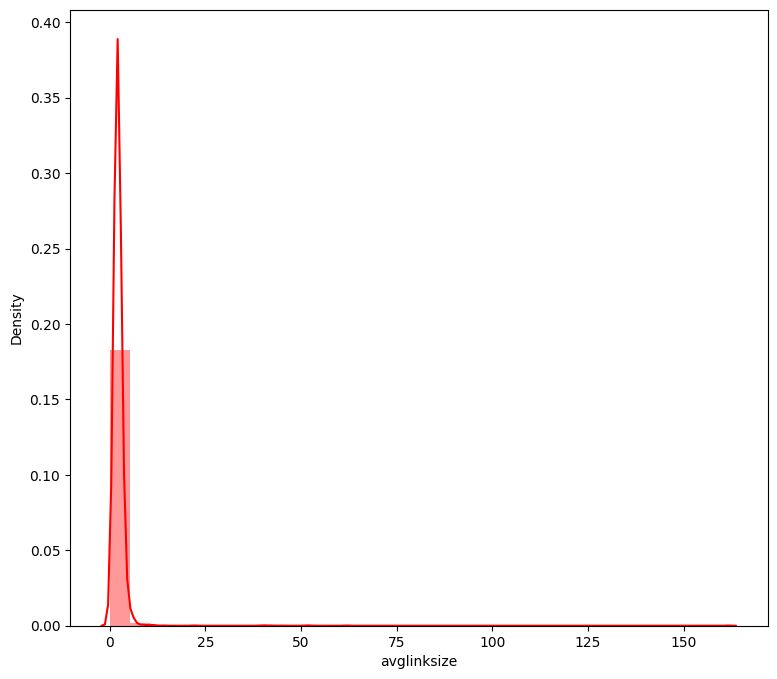

In [43]:
# Print the statistical summary (count, mean, std, min, max, etc.) of the 'avglinksize' column from the data2 DataFrame
print(data2['avglinksize'].describe())

# Create a new figure for the plot with a specific size (9x8 inches)
plt.figure(figsize=(9, 8))

# Plot the distribution of the 'avglinksize' column using Seaborn's distplot function
# Set the color of the plot to red ('r'), divide the data into 30 bins, and set transparency of the histogram to 0.4
sns.distplot(data2['avglinksize'], color='r', bins=30, hist_kws={'alpha': 0.4})


In [44]:
data2['avglinksize'].mean(),data2['avglinksize'].median()

(2.3618201571634887, 2.1)

In [45]:
# Create bins for 'avglinksize'
avglinksize_bins = [data2['avglinksize'].min(),
                    data2['avglinksize'].mean(),
                    data2['avglinksize'].mean() + data2['avglinksize'].std(),
                    data2['avglinksize'].max()]

# Split dataset acording to the bins
bins_df = pd.cut(data2['avglinksize'], bins=avglinksize_bins)

# Create groups with bins
data_set_size = data2.groupby(bins_df).size().reset_index(name='count')

print("Bins and sizes:")
print(data_set_size)


Bins and sizes:
        avglinksize  count
0      (0.0, 2.362]   2231
1    (2.362, 5.864]   1292
2  (5.864, 161.538]     40


In [46]:
data2['avglinksize'] = pd.cut(data2['avglinksize'],
                              bins=avglinksize_bins,
                              include_lowest=True,
                              duplicates='drop').cat.codes

count    3566.000000
mean        1.236298
std         3.803542
min         0.000000
25%         0.439223
50%         0.475962
75%         0.529072
max        21.000000
Name: compression_ratio, dtype: float64


<Axes: xlabel='compression_ratio', ylabel='Density'>

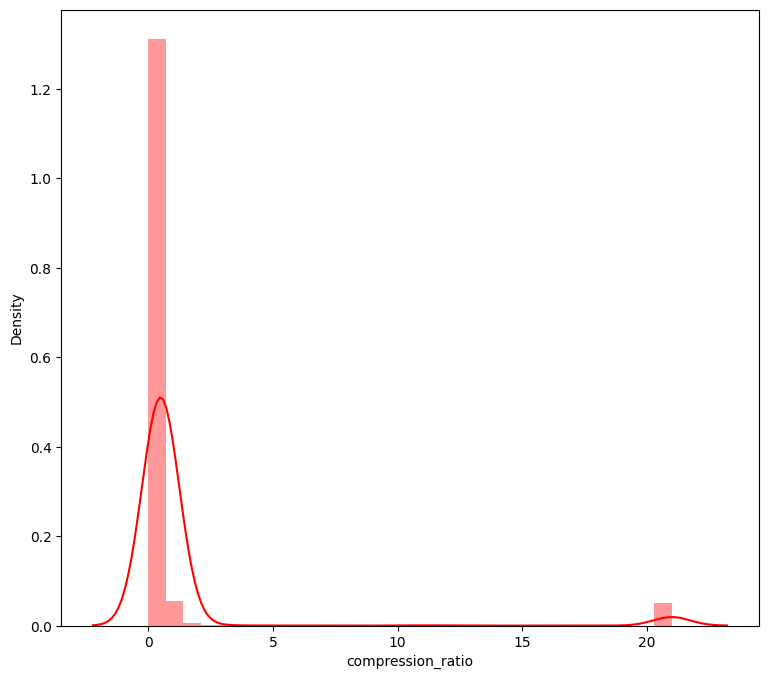

In [47]:
#compression_ratio
print(data2['compression_ratio'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(data2['compression_ratio'], color='r', bins=30, hist_kws={'alpha': 0.4})

In [48]:
# Create bins for 'compression_ratio'
compression_ratio_bins = [data2['compression_ratio'].min(),
                          data2['compression_ratio'].median(),
                          data2['compression_ratio'].median() + data2['compression_ratio'].std(),
                          data2['compression_ratio'].max()]

# Split dataset acording to the bins
bins_df = pd.cut(data2['compression_ratio'], bins=compression_ratio_bins)

# Create groups with bins
data_set_size = data2.groupby(bins_df).size().reset_index(name='count')

print("Bins and sizes:")
print(data_set_size)

Bins and sizes:
  compression_ratio  count
0      (0.0, 0.476]   1765
1     (0.476, 4.28]   1652
2      (4.28, 21.0]    131


In [49]:
data2[data2['compression_ratio'] == 0].shape

(18, 30)

In [50]:
data2['compression_ratio'] = pd.cut(data2['compression_ratio'],
                                    bins=compression_ratio_bins,
                                    include_lowest=True,
                                    duplicates='drop').cat.codes

count    3566.000000
mean        0.234122
std         1.169576
min        -1.000000
25%         0.033561
50%         0.085928
75%         0.222761
max        52.000000
Name: image_ratio, dtype: float64


<Axes: xlabel='image_ratio', ylabel='Density'>

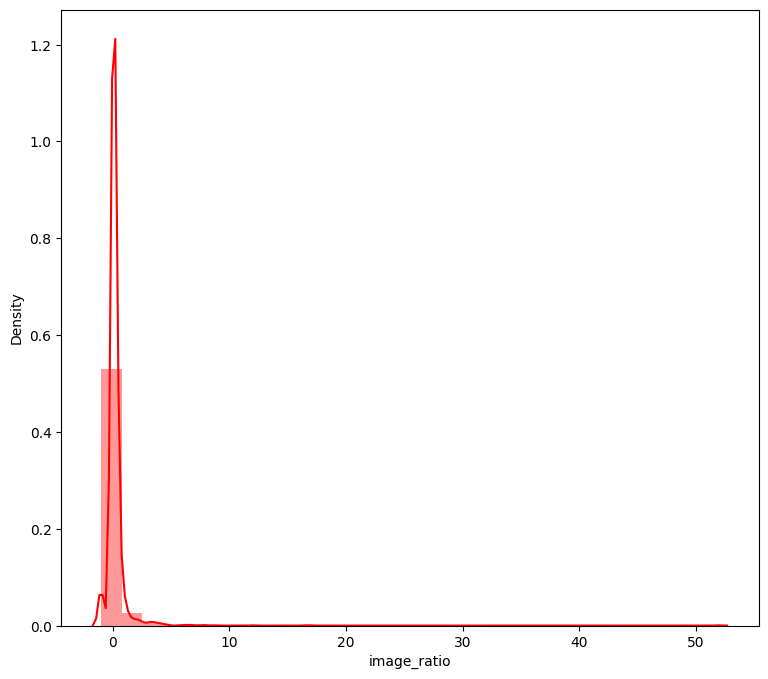

In [51]:
#image_ratio

print(data2['image_ratio'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(data2['image_ratio'], color='r', bins=30, hist_kws={'alpha': 0.4})

In [52]:
# Create bins for 'image_ratio'
image_ratio_bins = [data2['image_ratio'].min(),
                    0,
                    data2['image_ratio'].mean(),
                    data2['image_ratio'].mean() + data2['image_ratio'].std(),
                    data2['image_ratio'].max()]

# Split dataset acording to the bins
bins_df = pd.cut(data2['image_ratio'], bins=image_ratio_bins)

# Create groups with bins
data_set_size = data2.groupby(bins_df).size().reset_index(name='count')

print("Bins and sizes:")
print(data_set_size)

Bins and sizes:
      image_ratio  count
0     (-1.0, 0.0]      9
1    (0.0, 0.234]   2554
2  (0.234, 1.404]    739
3   (1.404, 52.0]    110


In [53]:
# Assign a new column 'image_ratio' to the 'data2' DataFrame by categorizing the values of the existing 'image_ratio' column.

# pd.cut() is used to segment the 'image_ratio' data into bins (ranges). It assigns each value in 'image_ratio' to a bin.
data2['image_ratio'] = pd.cut(data2['image_ratio'],
                              bins=image_ratio_bins,  # Use predefined bin edges in the 'image_ratio_bins' variable
                              include_lowest=True,    # Include the lowest value in the first bin
                              duplicates='drop').cat.codes  # Drop duplicate bins and convert categories to integer codes


count    3566.000000
mean       29.998598
std        19.351194
min         0.000000
25%        15.000000
50%        26.000000
75%        43.000000
max       100.000000
Name: linkwordscore, dtype: float64


<Axes: xlabel='linkwordscore', ylabel='Density'>

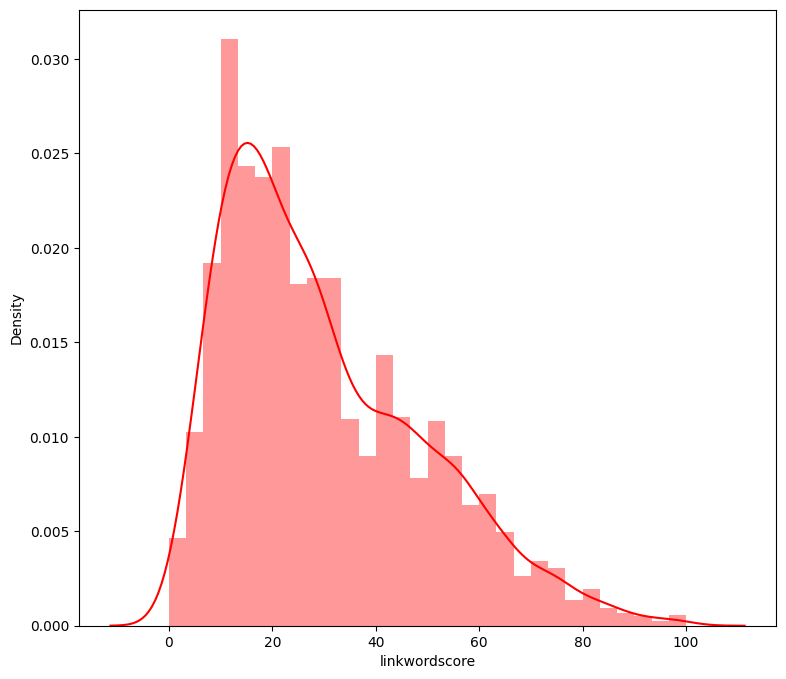

In [54]:
#linkwordscore

print(data2['linkwordscore'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(data2['linkwordscore'], color='r', bins=30, hist_kws={'alpha': 0.4})


In [55]:
# Create bins for 'linkwordscore'
linkwordscore_bins = [data2['linkwordscore'].min(),
                    data2['linkwordscore'].median() - data2['linkwordscore'].std(),
                    data2['linkwordscore'].median(),
                    data2['linkwordscore'].mean(),
                    data2['linkwordscore'].mean() + data2['linkwordscore'].std(),
                    data2['linkwordscore'].max()]

# Split dataset acording to the bins
bins_df = pd.cut(data2['linkwordscore'], bins=linkwordscore_bins)

# Create groups with bins
data_set_size = data2.groupby(bins_df).size().reset_index(name='count')

print("Bins and sizes:")
print(data_set_size)

Bins and sizes:
     linkwordscore  count
0     (0.0, 6.649]    173
1    (6.649, 26.0]   1684
2   (26.0, 29.999]    219
3  (29.999, 49.35]    850
4   (49.35, 100.0]    636


In [56]:
data2['linkwordscore'] = pd.cut(data2['linkwordscore'],
                                    bins=linkwordscore_bins,
                                    include_lowest=True,
                                    duplicates='drop').cat.codes

In [57]:
data2['linkwordscore'].head()

,linkwordscore
0,1
1,3
2,4
3,1
4,1


count     3566.000000
mean      5870.556366
std       7497.752539
min          0.000000
25%       1821.000000
50%       3834.500000
75%       6798.500000
max      87948.000000
Name: non_markup_alphanum_characters, dtype: float64


<Axes: xlabel='non_markup_alphanum_characters', ylabel='Density'>

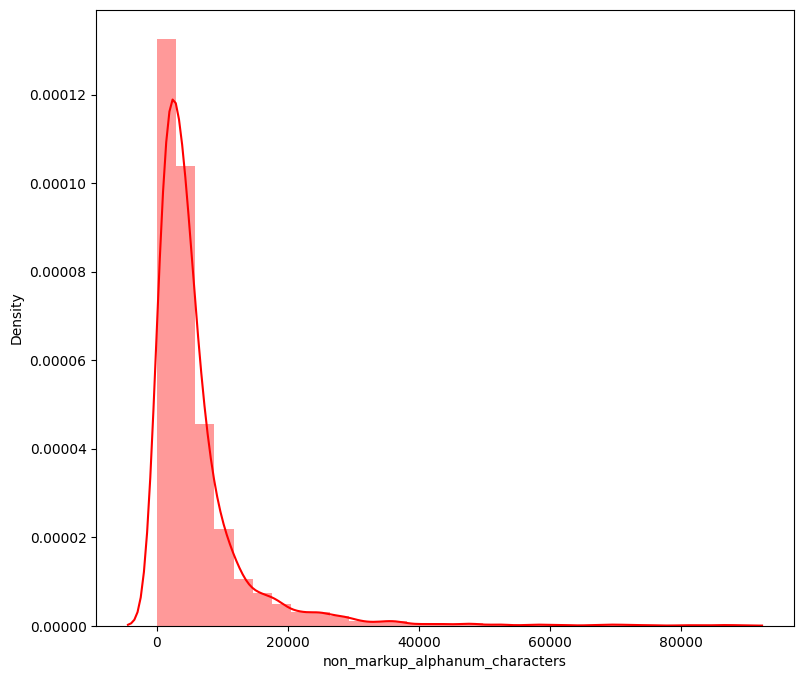

In [58]:
#non_markup_alphanum_characters

print(data2['non_markup_alphanum_characters'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(data2['non_markup_alphanum_characters'], color='r', bins=30, hist_kws={'alpha': 0.4})

In [59]:
data2[data2['non_markup_alphanum_characters'] == 0].shape

(2, 30)

In [60]:
# Create bins for 'non_markup_alphanum_characters'
non_markup_alphanum_characters_bins = [data2['non_markup_alphanum_characters'].min(),
                                       #data2['non_markup_alphanum_characters'].median(),
                                       data2['non_markup_alphanum_characters'].mean(),
                                       data2['non_markup_alphanum_characters'].mean() + data2['non_markup_alphanum_characters'].std(),
                                       data2['non_markup_alphanum_characters'].max()]

# Split dataset acording to the bins
bins_df = pd.cut(data2['non_markup_alphanum_characters'], bins=non_markup_alphanum_characters_bins)

# Create groups with bins
data_set_size = data2.groupby(bins_df).size().reset_index(name='count')

print("Bins and sizes:")
print(data_set_size)

Bins and sizes:
  non_markup_alphanum_characters  count
0                (0.0, 5870.556]   2470
1          (5870.556, 13368.309]    783
2           (13368.309, 87948.0]    311


In [61]:
data2['non_markup_alphanum_characters'] = pd.cut(data2['non_markup_alphanum_characters'],
                                    bins=non_markup_alphanum_characters_bins,
                                    include_lowest=True,
                                    duplicates='drop').cat.codes

count    3566.000000
mean      185.278744
std       154.052199
min         1.000000
25%        93.000000
50%       147.000000
75%       229.000000
max      3283.000000
Name: numberOfLinks, dtype: float64


<Axes: xlabel='numberOfLinks', ylabel='Density'>

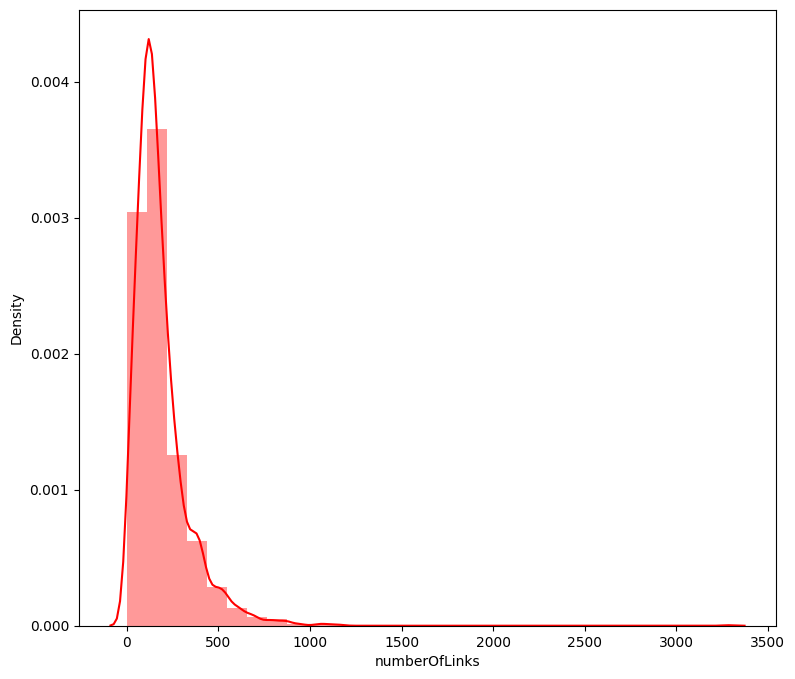

In [62]:
#numberOfLinks

print(data2['numberOfLinks'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(data2['numberOfLinks'], color='r', bins=30, hist_kws={'alpha': 0.4})

In [63]:
# Create bins for 'numberOfLinks'
numberOfLinks_bins = [data2['numberOfLinks'].min(),
                                       data2['numberOfLinks'].mean() - data2['numberOfLinks'].std(),
                                       data2['numberOfLinks'].median(),
                                       data2['numberOfLinks'].mean() + data2['numberOfLinks'].std(),
                                       data2['numberOfLinks'].max()]

# Split dataset acording to the bins
bins_df = pd.cut(data2['numberOfLinks'], bins=numberOfLinks_bins)

# Create groups with bins
data_set_size = data2.groupby(bins_df).size().reset_index(name='count')

print("Bins and sizes:")
print(data_set_size)

Bins and sizes:
       numberOfLinks  count
0      (1.0, 31.227]    210
1    (31.227, 147.0]   1584
2   (147.0, 339.331]   1326
3  (339.331, 3283.0]    444


In [64]:
data2['numberOfLinks'] = pd.cut(data2['numberOfLinks'],
                                    bins=numberOfLinks_bins,
                                    include_lowest=True,
                                    duplicates='drop').cat.codes

count    3566.000000
mean        5.323331
std         3.241569
min         0.000000
25%         3.000000
50%         5.000000
75%         7.000000
max        21.000000
Name: numwords_in_url, dtype: float64


<Axes: xlabel='numwords_in_url', ylabel='Density'>

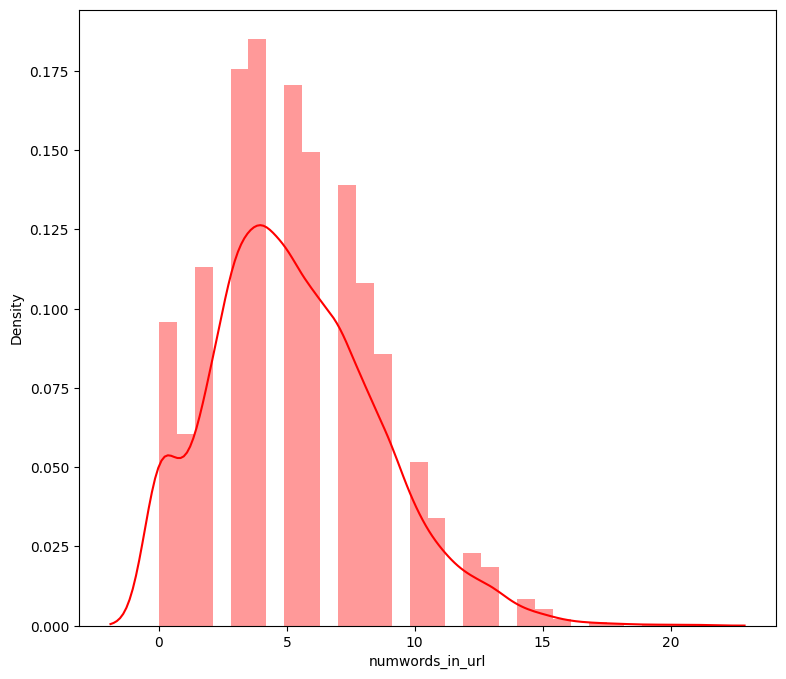

In [65]:
#numwords_in_url

print(data2['numwords_in_url'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(data2['numwords_in_url'], color='r', bins=30, hist_kws={'alpha': 0.4})

In [66]:
# Create bins for 'numwords_in_url'
numwords_in_url_bins = [data2['numwords_in_url'].min(),
                                       data2['numwords_in_url'].mean() - data2['numwords_in_url'].std(),
                                       data2['numwords_in_url'].mean(),
                                       data2['numwords_in_url'].mean() + data2['numwords_in_url'].std(),
                                       data2['numwords_in_url'].max()]

# Split dataset acording to the bins
bins_df = pd.cut(data2['numwords_in_url'], bins=numwords_in_url_bins)

# Create groups with bins
data_set_size = data2.groupby(bins_df).size().reset_index(name='count')

print("Bins and sizes:")
print(data_set_size)

Bins and sizes:
  numwords_in_url  count
0    (0.0, 2.082]    433
1  (2.082, 5.323]   1326
2  (5.323, 8.565]    990
3   (8.565, 21.0]    578


In [67]:
data2['numwords_in_url'] = pd.cut(data2['numwords_in_url'],
                                    bins=numwords_in_url_bins,
                                    include_lowest=True,
                                    duplicates='drop').cat.codes

In [68]:
data2.describe()

,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,lengthyLinkDomain,linkwordscore,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label,boilerplate_title_embedding,boilerplate_url_embedding,boilerplate_body_top_word_1,boilerplate_body_top_word_2,boilerplate_body_top_word_3,url_domain_page,Category
count,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.0,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000
mean,0.384745,0.480185,0.222428,0.097553,0.054697,0.536736,-0.056567,0.0,0.058061,0.019349,0.232715,1.223219,0.720415,2.023556,0.393999,1.561413,1.413348,0.164460,0.096689,0.517667,-0.010004,-0.004747,494.808469,545.173303,564.113573,750.558329,0.528001
std,0.509140,0.184105,0.138361,0.093458,0.073537,0.567638,0.232502,0.0,0.039592,0.137769,0.043971,0.571486,0.448858,1.273753,0.642888,0.783786,0.971505,0.162414,0.053385,0.499758,0.001157,0.006177,429.561199,468.871561,487.486482,473.256034,0.186828
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.0,0.000000,0.000000,0.075224,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.013711,-0.033977,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.363636,0.121910,0.029126,0.000000,0.000000,0.000000,0.0,0.031682,0.000000,0.204238,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.045918,0.071806,0.000000,-0.011080,-0.009009,63.250000,62.000000,64.250000,289.250000,0.417000
50%,0.000000,0.491427,0.214130,0.077754,0.028856,0.500000,0.000000,0.0,0.047908,0.000000,0.230650,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.117483,0.089765,1.000000,-0.009800,-0.004051,413.000000,482.500000,490.000000,687.000000,0.500000
75%,1.000000,0.612397,0.301518,0.138889,0.075170,1.000000,0.000000,0.0,0.074576,0.000000,0.258400,1.000000,1.000000,3.000000,1.000000,2.000000,2.000000,0.227550,0.109997,1.000000,-0.009118,0.000000,878.000000,955.750000,985.000000,1161.000000,0.750000
max,2.000000,1.000000,0.982906,0.948718,0.948718,2.000000,0.214286,0.0,0.421053,1.000000,0.506146,3.000000,1.000000,4.000000,2.000000,3.000000,3.000000,1.000000,1.000000,1.000000,-0.007223,0.019597,1329.000000,1439.000000,1490.000000,1603.000000,1.000000


In [69]:
# Potential feature for MinMax Scaler
scale_cols = ['avglinksize', 'compression_ratio', 'image_ratio', 'linkwordscore',
              'non_markup_alphanum_characters', 'numberOfLinks', 'numwords_in_url',
              'boilerplate_body_top_word_1', 'boilerplate_body_top_word_2', 'boilerplate_body_top_word_3', 'url_domain_page']



In [70]:


# Function to apply Min-Max scaling to specific columns of a DataFrame
def scale_columns(dataframe, columns_to_scale):
    """
    This function applies Min-Max scaling to the specified columns of a DataFrame.

    Parameters:
    dataframe (pd.DataFrame): The input DataFrame with the data.
    columns_to_scale (list): A list of column names to be scaled.

    Returns:
    pd.DataFrame: The DataFrame with scaled columns.
    """

    # Initialize MinMaxScaler
    scaler = MinMaxScaler()

    # Apply the scaler only to the specified columns
    dataframe[columns_to_scale] = scaler.fit_transform(dataframe[columns_to_scale])

    return dataframe

data2 = scale_columns(data2, scale_cols)

# Display the first few rows of the scaled dataframe
data2.head()


,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label,boilerplate_title_embedding,boilerplate_url_embedding,boilerplate_body_top_word_1,boilerplate_body_top_word_2,boilerplate_body_top_word_3,url_domain_page,Category
0,0.789131,0.0,0.676471,0.205882,0.047059,0.023529,0.0,0.0,0,0.090774,0,0.245831,0.333333,1,1,0.25,0,0.0,0.666667,0.666667,0.152941,0.079130,0,-0.009052,-0.006092,0.414597,0.739402,0.773826,0.111042,0.750
1,0.574147,0.5,0.508021,0.288770,0.213904,0.144385,0.0,0.0,0,0.098707,0,0.203490,0.333333,1,1,0.75,0,0.0,0.666667,1.000000,0.181818,0.125448,1,-0.009276,-0.007521,0.375470,0.831828,0.832886,0.675608,0.417
2,0.996526,0.5,0.562016,0.321705,0.120155,0.042636,0.5,0.0,0,0.072448,0,0.226402,0.333333,1,1,1.00,0,0.0,0.666667,1.000000,0.166667,0.057613,1,-0.007609,-0.007592,0.602709,0.955525,0.125503,0.537118,0.333
3,0.801248,0.0,0.400000,0.100000,0.016667,0.000000,0.5,0.0,0,0.095861,0,0.265656,0.333333,1,0,0.25,0,0.0,0.333333,0.333333,0.041667,0.100858,1,-0.010093,-0.012470,0.817908,0.599722,0.431544,0.228322,0.333
4,0.719157,0.5,0.500000,0.222222,0.123457,0.043210,0.0,0.0,0,0.024908,0,0.228887,0.333333,1,1,0.25,0,0.5,0.666667,1.000000,0.098765,0.082569,0,-0.009873,-0.002482,0.443190,0.893676,0.595973,0.106675,0.250


In [71]:
data2.describe()

,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,lengthyLinkDomain,linkwordscore,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label,boilerplate_title_embedding,boilerplate_url_embedding,boilerplate_body_top_word_1,boilerplate_body_top_word_2,boilerplate_body_top_word_3,url_domain_page,Category
count,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.0,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000
mean,0.192372,0.480185,0.222428,0.097553,0.054697,0.268368,-0.056567,0.0,0.058061,0.019349,0.232715,0.407740,0.720415,0.505889,0.196999,0.520471,0.471116,0.164460,0.096689,0.517667,-0.010004,-0.004747,0.372316,0.378856,0.378600,0.468221,0.528001
std,0.254570,0.184105,0.138361,0.093458,0.073537,0.283819,0.232502,0.0,0.039592,0.137769,0.043971,0.190495,0.448858,0.318438,0.321444,0.261262,0.323835,0.162414,0.053385,0.499758,0.001157,0.006177,0.323221,0.325832,0.327172,0.295231,0.186828
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.0,0.000000,0.000000,0.075224,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.013711,-0.033977,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.363636,0.121910,0.029126,0.000000,0.000000,0.000000,0.0,0.031682,0.000000,0.204238,0.333333,0.000000,0.250000,0.000000,0.333333,0.333333,0.045918,0.071806,0.000000,-0.011080,-0.009009,0.047592,0.043085,0.043121,0.180443,0.417000
50%,0.000000,0.491427,0.214130,0.077754,0.028856,0.250000,0.000000,0.0,0.047908,0.000000,0.230650,0.333333,1.000000,0.250000,0.000000,0.333333,0.333333,0.117483,0.089765,1.000000,-0.009800,-0.004051,0.310760,0.335302,0.328859,0.428571,0.500000
75%,0.500000,0.612397,0.301518,0.138889,0.075170,0.500000,0.000000,0.0,0.074576,0.000000,0.258400,0.333333,1.000000,0.750000,0.500000,0.666667,0.666667,0.227550,0.109997,1.000000,-0.009118,0.000000,0.660647,0.664177,0.661074,0.724267,0.750000
max,1.000000,1.000000,0.982906,0.948718,0.948718,1.000000,0.214286,0.0,0.421053,1.000000,0.506146,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.007223,0.019597,1.000000,1.000000,1.000000,1.000000,1.000000


In [72]:
# Method for reducing the memory usage


def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [73]:
data2 = reduce_mem_usage(data2)


Mem. usage decreased to  0.40 Mb (58.2% reduction)


In [74]:
data2.label.value_counts()

,count
label,
1,1846
0,1720


In [75]:
data2.columns

Index(['alchemy_category_score', 'avglinksize', 'commonlinkratio_1', 'commonlinkratio_2', 'commonlinkratio_3', 'commonlinkratio_4', 'compression_ratio', 'embed_ratio', 'framebased', 'frameTagRatio', 'hasDomainLink', 'html_ratio', 'image_ratio', 'is_news', 'lengthyLinkDomain', 'linkwordscore', 'news_front_page', 'non_markup_alphanum_characters', 'numberOfLinks', 'numwords_in_url', 'parametrizedLinkRatio', 'spelling_errors_ratio', 'label', 'boilerplate_title_embedding', 'boilerplate_url_embedding', 'boilerplate_body_top_word_1', 'boilerplate_body_top_word_2', 'boilerplate_body_top_word_3', 'url_domain_page', 'Category'], dtype='object')

In [77]:
data2.columns.to_list()[22]

'label'

In [82]:
# Calculating correlation
corr_df = data2.copy()

df_corr = corr_df[corr_df.columns.to_list()[:22] +
                  corr_df.columns.to_list()[23:] +
                  [corr_df.columns.to_list()[22]]]

corr = df_corr.corr()
cr = corr.copy()
top_corr_columns = []
#Determine best correlate columns over 0.1
top_corr_columns = cr.loc[:, 'label'][:-1]
best_accurate_columns = top_corr_columns[abs(top_corr_columns) > 0.05].sort_values(ascending=False)


len(best_accurate_columns)

15

In [89]:
best_accurate_columns.keys()

Index(['non_markup_alphanum_characters', 'commonlinkratio_3', 'Category', 'commonlinkratio_4', 'numberOfLinks', 'commonlinkratio_2', 'image_ratio', 'numwords_in_url', 'alchemy_category_score', 'avglinksize', 'spelling_errors_ratio', 'compression_ratio', 'frameTagRatio', 'linkwordscore', 'boilerplate_url_embedding'], dtype='object')

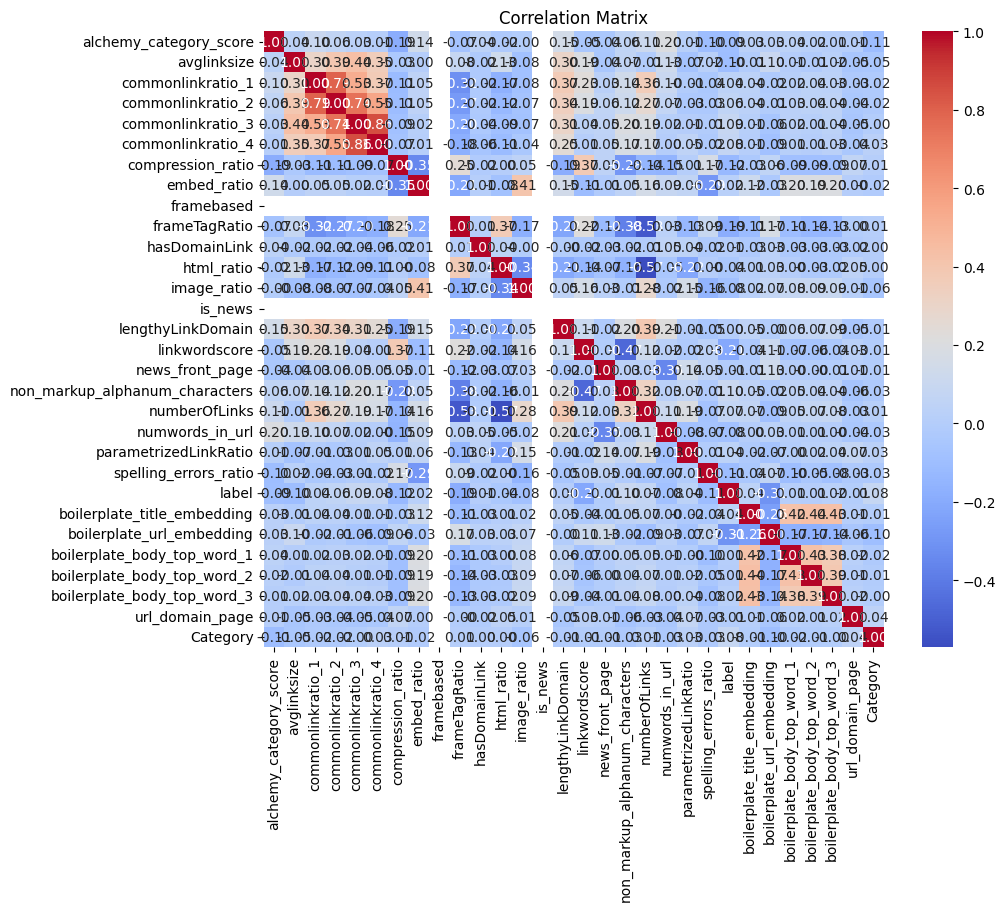

In [86]:

# Calculate and visualize correlation matrix
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix")
    plt.show()

plot_correlation_matrix(corr_df)

In [92]:
data3 = data2[best_accurate_columns.keys()].copy()
data3['label'] = data2['label']
data3.head()

,non_markup_alphanum_characters,commonlinkratio_3,Category,commonlinkratio_4,numberOfLinks,commonlinkratio_2,image_ratio,numwords_in_url,alchemy_category_score,avglinksize,spelling_errors_ratio,compression_ratio,frameTagRatio,linkwordscore,boilerplate_url_embedding,label
0,0.0,0.047058,0.750000,0.023529,0.666504,0.205933,0.333252,0.666504,0.789131,0.0,0.079102,0.0,0.090759,0.25,-0.006092,0
1,0.0,0.213867,0.416992,0.144409,0.666504,0.288818,0.333252,1.000000,0.574147,0.5,0.125488,0.0,0.098694,0.75,-0.007523,1
2,0.0,0.120178,0.333008,0.042633,0.666504,0.321777,0.333252,1.000000,0.996526,0.5,0.057617,0.5,0.072449,1.00,-0.007591,1
3,0.0,0.016663,0.333008,0.000000,0.333252,0.099976,0.333252,0.333252,0.801248,0.0,0.100830,0.5,0.095886,0.25,-0.012466,1
4,0.5,0.123474,0.250000,0.043213,0.666504,0.222168,0.333252,1.000000,0.719157,0.5,0.082581,0.0,0.024902,0.25,-0.002481,0


In [93]:
X = data3.drop(['label'], axis=1) #features (independent variables)
y = data3['label'] #target (dependent variable)


In [94]:
# Check for NaN or infinite values
print(X.isnull().sum())
print(y.isnull().sum())


non_markup_alphanum_characters    0
commonlinkratio_3                 0
Category                          0
commonlinkratio_4                 0
numberOfLinks                     0
commonlinkratio_2                 0
image_ratio                       0
numwords_in_url                   0
alchemy_category_score            0
avglinksize                       0
spelling_errors_ratio             0
compression_ratio                 0
frameTagRatio                     0
linkwordscore                     0
boilerplate_url_embedding         0
dtype: int64
0


In [95]:
# Split the dataset into training and testing sets.
# 'train_test_split' is used to split the features (X) and target (y) into training and test sets.

X_train, X_test, y_train, y_test = train_test_split(
    X,            # Feature data (input)
    y,            # Target data (output/labels)
    test_size=0.2,  # 20% of the data will be assigned to the test set, 80% to the training set
    random_state=42  # Ensures the split is reproducible (same split each time)
)


In [96]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2852, 15), (714, 15), (2852,), (714,))

In [97]:
print(X_train.dtypes)  # For pandas DataFrame
print(y_train.dtype)    # For y_train


non_markup_alphanum_characters    float16
commonlinkratio_3                 float16
Category                          float16
commonlinkratio_4                 float16
numberOfLinks                     float16
commonlinkratio_2                 float16
image_ratio                       float16
numwords_in_url                   float16
alchemy_category_score             object
avglinksize                       float16
spelling_errors_ratio             float16
compression_ratio                 float16
frameTagRatio                     float16
linkwordscore                     float16
boilerplate_url_embedding         float16
dtype: object
int8


#RandomForestClassifier



In [98]:
# Defining hyperparameter values for the Random Forest Classifier

n_estimators = [700]            # Number of trees in the forest (using 700 trees)
max_depth = [10, 8]             # Maximum depth of each tree (testing depths of 10 and 8)
min_samples_split = [10, 5]     # Minimum number of samples required to split an internal node (testing values 10 and 5)
min_samples_leaf = [5, 3]       # Minimum number of samples required to be a leaf node (testing values 5 and 3)

# Creating a dictionary that stores these hyperparameter options
hyper_random = {
    "n_estimators": n_estimators,              # Number of trees to be used
    "max_depth": max_depth,                    # Maximum tree depths to be used
    "min_samples_split": min_samples_split,    # Minimum samples required for splitting a node
    "min_samples_leaf": min_samples_leaf       # Minimum samples required for a leaf node
}


In [99]:
X_train.head()

,non_markup_alphanum_characters,commonlinkratio_3,Category,commonlinkratio_4,numberOfLinks,commonlinkratio_2,image_ratio,numwords_in_url,alchemy_category_score,avglinksize,spelling_errors_ratio,compression_ratio,frameTagRatio,linkwordscore,boilerplate_url_embedding
305,1.0,0.115234,0.666992,0.078125,1.000000,0.292969,0.333252,0.333252,0.797096,0.5,0.109985,0.0,0.037750,0.25,-0.008545
3921,0.0,0.000000,0.750000,0.000000,0.666504,0.227295,0.666504,0.666504,0.699025,0.0,0.113220,0.5,0.059570,1.00,0.000000
1357,0.0,0.093750,0.250000,0.062500,0.333252,0.218750,0.333252,0.666504,0.727014,0.5,0.072144,0.5,0.098755,0.50,-0.008957
1606,0.5,0.060608,0.750000,0.030304,0.333252,0.060608,0.333252,0.333252,0.555337,0.0,0.102905,0.0,0.054138,0.00,-0.001580
6191,0.0,0.000000,0.916992,0.000000,0.000000,0.000000,0.333252,0.000000,0.464386,0.0,0.087708,0.5,0.218750,0.25,0.000000


In [100]:
%%time
# Perform Grid Search to find the best hyperparameters for Random Forest Classifier

clf_rf_tuned = GridSearchCV(RandomForestClassifier(),   # The model being tuned is a Random Forest Classifier
                            hyper_random,               # The hyperparameter grid defined earlier
                            cv=5,                       # 5-fold cross-validation
                            verbose=1,                  # Verbosity level (1 = prints progress)
                            n_jobs=-1)                  # Use all available CPU cores to parallelize the work

# Fit the model on the training data
clf_rf_tuned.fit(X_train, y_train)                      # Train the model with X_train as input and y_train as the target variable


Fitting 5 folds for each of 8 candidates, totalling 40 fits
CPU times: user 6.27 s, sys: 806 ms, total: 7.08 s
Wall time: 2min 34s


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 8], 'min_samples_leaf': [5, 3],
                         'min_samples_split': [10, 5], 'n_estimators': [700]},
             verbose=1)

In [101]:
best_params_random = clf_rf_tuned.best_params_
print(best_params_random)

{'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 700}


In [102]:
# Parameter settings
CV_clf_rf = RandomForestClassifier(max_depth=best_params_random["max_depth"],
                                   min_samples_leaf=best_params_random["min_samples_leaf"],
                                   min_samples_split=best_params_random["min_samples_split"],
                                   n_estimators= best_params_random["n_estimators"])

In [103]:
# Fit the model (CV_clf_rf) on the training data
CV_clf_rf.fit(X_train, y_train)

# Predict the probabilities for the test data (specifically the probability of class 1)
y_test_predict_random = CV_clf_rf.predict_proba(X_test)[:, 1]

# Predict the class labels for the test data
yhat_random = CV_clf_rf.predict(X_test)

# Compute the calibration curve (fraction of positives vs. mean predicted value)
fraction_of_positives, mean_predicted_value = calibration_curve(y_test,
                                                                y_test_predict_random,
                                                                n_bins=10)


In [104]:
# Print the classification report of the model's predictions on the test data
print(classification_report(y_test, yhat_random))


              precision    recall  f1-score   support

           0       0.70      0.74      0.72       349
           1       0.73      0.70      0.71       365

    accuracy                           0.72       714
   macro avg       0.72      0.72      0.72       714
weighted avg       0.72      0.72      0.72       714



In [105]:
# Create Final dataset
final_data = data.loc[data.index.intersection(X_test.index)]
final_data.shape, X_test.shape

((714, 39), (714, 15))

In [106]:
final_data.head()

,url,urlid,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label,boilerplate_title,boilerplate_body,boilerplate_url,processed_boilerplate_title,boilerplate_title_embedding,processed_boilerplate_url,boilerplate_url_embedding,processed_boilerplate_body,boilerplate_body_top_word_1,boilerplate_body_top_word_2,boilerplate_body_top_word_3,url_domain_page,Category
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0,0.090774,0,0.245831,0.003883,1,1,24,0,5424,170,8,0.152941,0.079130,0,IBM Sees Holographic Calls Air Breathing Batte...,A sign stands outside the International Busine...,bloomberg news 2010 12 23 ibm predicts hologra...,ibm sees holographic calls air breathing batte...,"[-0.6513698697090149, 0.1557663232088089, -0.3...",bloomberg news ibm predicts holographic calls ...,"[-0.01027832, 0.04192505, -0.033117674, 0.0211...",sign stands outside international business mac...,551,1064,1153,178,0.750
12,http://www.ivillage.com/our-dirty-mouths/4-b-1...,1917,health,0.872323,3.056911,0.595588,0.227941,0.044118,0.014706,0.573109,0.0,0,0.074576,0,0.236281,0.084112,1,1,64,0,1062,136,9,0.169118,0.180328,1,9 Foods That Trash Your Teeth,There are the 700 different types of germs in ...,ivillage our dirty mouths 4 b 188305 iv NPA 1 ...,foods trash teeth,"[-0.07376822084188461, 0.3692306876182556, -0....",ivillage dirty mouths b iv npa sky stu ths aqu...,"[-0.07027588, 0.034979247, 0.031640626, 0.1492...",different types germs mouth cause cavities say...,766,489,1332,707,0.333
26,http://breakingnewsblog.com/,7298,sports,0.348995,3.355263,0.488372,0.290698,0.081395,0.023256,0.573826,0.0,0,0.007968,0,0.348059,0.004608,1,1,98,1,21,86,0,0.000000,0.128440,0,Breaking News Blog,Contact Empty List Empty List Empty List Katie...,breakingnewsblog,breaking news blog,"[-0.2743833065032959, -0.019600823521614075, -...",breakingnewsblog,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",contact empty list empty list empty list katie...,662,412,1364,194,0.250
37,http://www.collegehumor.com/video:1806201,1650,arts_entertainment,0.519337,1.549451,0.417910,0.114428,0.004975,0.004975,0.569044,0.0,0,0.040764,0,0.256810,0.183206,1,0,37,0,2382,201,1,0.014925,0.092308,0,Pogo Shoes CollegeHumor Video pogo shoes,Drink Thief My room mate has this annoying hab...,collegehumor video 1806201,pogo shoes collegehumor video pogo shoes,"[-0.2335113137960434, -0.10156134516000748, -0...",collegehumor video,"[-0.022338867, -0.004547119, -0.100097656, 0.0...",drink thief room mate annoying habit stealing ...,1066,1087,517,266,0.500
56,http://www.marcandangel.com/2010/03/22/9-timel...,6006,sports,0.34619,3.660606,0.591398,0.370968,0.279570,0.225806,0.488655,0.0,0,0.030303,0,0.274791,0.038580,1,1,24,0,8191,186,6,0.064516,0.082148,1,9 Timeless Nutrition Tips for Any Age 9 timele...,March 22nd 2010 1 55 am by Marc This guest pos...,marcandangel 2010 03 22 9 timeless nutrition t...,timeless nutrition tips age timeless nutrition...,"[-0.08603144437074661, 0.1794956624507904, 0.4...",marcandangel timeless nutrition tips age,"[0.07495117, 0.1333313, -0.032348633, 0.006591...",march nd marc guest post written nicole author...,1157,488,409,841,0.250


In [107]:
def move_column_to_end(df, column_name):
    """
    Move a specified column to the end of the DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the column to move to the end.

    Returns:
        pd.DataFrame: A new DataFrame with the specified column at the end.
    """
    # Check if the column name exists in the dataframe
    if column_name in df.columns:
        # Create a new DataFrame that excludes the specified column
        df_without_column = df.drop(columns=[column_name])
        # Concatenate the excluded column at the end
        df_new_order = pd.concat([df_without_column, df[[column_name]]], axis=1)
        return df_new_order
    else:
        print(f"Column name '{column_name}' does not exist in the DataFrame.")
        return df  # Return the original DataFrame unchanged if the column is not found

In [108]:
final_data = move_column_to_end(final_data, 'label')
final_data.head()

,url,urlid,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,boilerplate_title,boilerplate_body,boilerplate_url,processed_boilerplate_title,boilerplate_title_embedding,processed_boilerplate_url,boilerplate_url_embedding,processed_boilerplate_body,boilerplate_body_top_word_1,boilerplate_body_top_word_2,boilerplate_body_top_word_3,url_domain_page,Category,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0,0.090774,0,0.245831,0.003883,1,1,24,0,5424,170,8,0.152941,0.079130,IBM Sees Holographic Calls Air Breathing Batte...,A sign stands outside the International Busine...,bloomberg news 2010 12 23 ibm predicts hologra...,ibm sees holographic calls air breathing batte...,"[-0.6513698697090149, 0.1557663232088089, -0.3...",bloomberg news ibm predicts holographic calls ...,"[-0.01027832, 0.04192505, -0.033117674, 0.0211...",sign stands outside international business mac...,551,1064,1153,178,0.750,0
12,http://www.ivillage.com/our-dirty-mouths/4-b-1...,1917,health,0.872323,3.056911,0.595588,0.227941,0.044118,0.014706,0.573109,0.0,0,0.074576,0,0.236281,0.084112,1,1,64,0,1062,136,9,0.169118,0.180328,9 Foods That Trash Your Teeth,There are the 700 different types of germs in ...,ivillage our dirty mouths 4 b 188305 iv NPA 1 ...,foods trash teeth,"[-0.07376822084188461, 0.3692306876182556, -0....",ivillage dirty mouths b iv npa sky stu ths aqu...,"[-0.07027588, 0.034979247, 0.031640626, 0.1492...",different types germs mouth cause cavities say...,766,489,1332,707,0.333,1
26,http://breakingnewsblog.com/,7298,sports,0.348995,3.355263,0.488372,0.290698,0.081395,0.023256,0.573826,0.0,0,0.007968,0,0.348059,0.004608,1,1,98,1,21,86,0,0.000000,0.128440,Breaking News Blog,Contact Empty List Empty List Empty List Katie...,breakingnewsblog,breaking news blog,"[-0.2743833065032959, -0.019600823521614075, -...",breakingnewsblog,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",contact empty list empty list empty list katie...,662,412,1364,194,0.250,0
37,http://www.collegehumor.com/video:1806201,1650,arts_entertainment,0.519337,1.549451,0.417910,0.114428,0.004975,0.004975,0.569044,0.0,0,0.040764,0,0.256810,0.183206,1,0,37,0,2382,201,1,0.014925,0.092308,Pogo Shoes CollegeHumor Video pogo shoes,Drink Thief My room mate has this annoying hab...,collegehumor video 1806201,pogo shoes collegehumor video pogo shoes,"[-0.2335113137960434, -0.10156134516000748, -0...",collegehumor video,"[-0.022338867, -0.004547119, -0.100097656, 0.0...",drink thief room mate annoying habit stealing ...,1066,1087,517,266,0.500,0
56,http://www.marcandangel.com/2010/03/22/9-timel...,6006,sports,0.34619,3.660606,0.591398,0.370968,0.279570,0.225806,0.488655,0.0,0,0.030303,0,0.274791,0.038580,1,1,24,0,8191,186,6,0.064516,0.082148,9 Timeless Nutrition Tips for Any Age 9 timele...,March 22nd 2010 1 55 am by Marc This guest pos...,marcandangel 2010 03 22 9 timeless nutrition t...,timeless nutrition tips age timeless nutrition...,"[-0.08603144437074661, 0.1794956624507904, 0.4...",marcandangel timeless nutrition tips age,"[0.07495117, 0.1333313, -0.032348633, 0.006591...",march nd marc guest post written nicole author...,1157,488,409,841,0.250,1


In [109]:
final_data['random_forest_pred'] = yhat_random

#GaussianNaiveBias



In [110]:
%%time

#Uncalibrated Gaussian Naive Bayes classifier
clf_nb = GaussianNB()  # Initialize a Gaussian Naive Bayes classifier
clf_nb.fit(X_train, y_train)  # Train the model on the training data

y_test_predict_nb = clf_nb.predict_proba(X_test)[:, 1]  # Get probability predictions for the test set
yhat_nb = clf_nb.predict(X_test)  # Get class predictions for the test set

fraction_of_positives_nb, mean_predicted_value_nb = calibration_curve(y_test, y_test_predict_nb, n_bins=10)



# Calibrated  with isotonic NB
clf_sigmoid_nb = CalibratedClassifierCV(clf_nb, cv=10, method='isotonic')  # Initialize isotonic calibration
clf_sigmoid_nb.fit(X_train, y_train)  # Calibrate the classifier using 10-fold cross-validation

y_test_predict_nb_calib = clf_sigmoid_nb.predict_proba(X_test)[:, 1]  # Get calibrated probability predictions
yhat_calibrated_nb = clf_sigmoid_nb.predict(X_test)  # Get calibrated class predictions

fraction_of_positives_nb_calib, mean_predicted_value_nb_calib = calibration_curve(y_test, y_test_predict_nb_calib, n_bins=10)


CPU times: user 286 ms, sys: 883 µs, total: 287 ms
Wall time: 301 ms


In [111]:
print(classification_report(y_test, yhat_nb))


              precision    recall  f1-score   support

           0       0.65      0.57      0.61       349
           1       0.63      0.71      0.67       365

    accuracy                           0.64       714
   macro avg       0.64      0.64      0.64       714
weighted avg       0.64      0.64      0.64       714



In [112]:
print(classification_report(y_test, yhat_calibrated_nb))


              precision    recall  f1-score   support

           0       0.65      0.65      0.65       349
           1       0.66      0.66      0.66       365

    accuracy                           0.66       714
   macro avg       0.66      0.66      0.66       714
weighted avg       0.66      0.66      0.66       714



In [113]:
final_data['Naive_Bias_Pred'] = yhat_nb
final_data['Isotonic_Calibrated_Naive_Bias_Pred'] = yhat_calibrated_nb

final_data.head()

,url,urlid,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,boilerplate_title,boilerplate_body,boilerplate_url,processed_boilerplate_title,boilerplate_title_embedding,processed_boilerplate_url,boilerplate_url_embedding,processed_boilerplate_body,boilerplate_body_top_word_1,boilerplate_body_top_word_2,boilerplate_body_top_word_3,url_domain_page,Category,label,random_forest_pred,Naive_Bias_Pred,Isotonic_Calibrated_Naive_Bias_Pred
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0,0.090774,0,0.245831,0.003883,1,1,24,0,5424,170,8,0.152941,0.079130,IBM Sees Holographic Calls Air Breathing Batte...,A sign stands outside the International Busine...,bloomberg news 2010 12 23 ibm predicts hologra...,ibm sees holographic calls air breathing batte...,"[-0.6513698697090149, 0.1557663232088089, -0.3...",bloomberg news ibm predicts holographic calls ...,"[-0.01027832, 0.04192505, -0.033117674, 0.0211...",sign stands outside international business mac...,551,1064,1153,178,0.750,0,0,1,1
12,http://www.ivillage.com/our-dirty-mouths/4-b-1...,1917,health,0.872323,3.056911,0.595588,0.227941,0.044118,0.014706,0.573109,0.0,0,0.074576,0,0.236281,0.084112,1,1,64,0,1062,136,9,0.169118,0.180328,9 Foods That Trash Your Teeth,There are the 700 different types of germs in ...,ivillage our dirty mouths 4 b 188305 iv NPA 1 ...,foods trash teeth,"[-0.07376822084188461, 0.3692306876182556, -0....",ivillage dirty mouths b iv npa sky stu ths aqu...,"[-0.07027588, 0.034979247, 0.031640626, 0.1492...",different types germs mouth cause cavities say...,766,489,1332,707,0.333,1,0,0,0
26,http://breakingnewsblog.com/,7298,sports,0.348995,3.355263,0.488372,0.290698,0.081395,0.023256,0.573826,0.0,0,0.007968,0,0.348059,0.004608,1,1,98,1,21,86,0,0.000000,0.128440,Breaking News Blog,Contact Empty List Empty List Empty List Katie...,breakingnewsblog,breaking news blog,"[-0.2743833065032959, -0.019600823521614075, -...",breakingnewsblog,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",contact empty list empty list empty list katie...,662,412,1364,194,0.250,0,1,1,1
37,http://www.collegehumor.com/video:1806201,1650,arts_entertainment,0.519337,1.549451,0.417910,0.114428,0.004975,0.004975,0.569044,0.0,0,0.040764,0,0.256810,0.183206,1,0,37,0,2382,201,1,0.014925,0.092308,Pogo Shoes CollegeHumor Video pogo shoes,Drink Thief My room mate has this annoying hab...,collegehumor video 1806201,pogo shoes collegehumor video pogo shoes,"[-0.2335113137960434, -0.10156134516000748, -0...",collegehumor video,"[-0.022338867, -0.004547119, -0.100097656, 0.0...",drink thief room mate annoying habit stealing ...,1066,1087,517,266,0.500,0,0,0,0
56,http://www.marcandangel.com/2010/03/22/9-timel...,6006,sports,0.34619,3.660606,0.591398,0.370968,0.279570,0.225806,0.488655,0.0,0,0.030303,0,0.274791,0.038580,1,1,24,0,8191,186,6,0.064516,0.082148,9 Timeless Nutrition Tips for Any Age 9 timele...,March 22nd 2010 1 55 am by Marc This guest pos...,marcandangel 2010 03 22 9 timeless nutrition t...,timeless nutrition tips age timeless nutrition...,"[-0.08603144437074661, 0.1794956624507904, 0.4...",marcandangel timeless nutrition tips age,"[0.07495117, 0.1333313, -0.032348633, 0.006591...",march nd marc guest post written nicole author...,1157,488,409,841,0.250,1,0,0,0


In [114]:
final_data['rf_prob'] = y_test_predict_random
final_data['nb_prob'] = y_test_predict_nb
final_data['cnb_prob'] = y_test_predict_nb_calib

In [119]:
def calc_label_score(final_df):
    # Calculate the Label_Score by taking a weighted sum of probabilities from three models:
    # Random Forest ('rf_prob'), Naive Bayes ('nb_prob'), and Complement Naive Bayes ('cnb_prob')
    # The weights for each probability are 0.72, 0.64, and 0.65 respectively.
    final_df['Label_Score'] = ((final_df['rf_prob']*0.72) +
                               (final_df['nb_prob']*0.64) +
                               (final_df['cnb_prob']*0.65))

    # Define a normalization function that scales the data between 0 and 1
    def NormalizeData(data):
        return (data - np.min(data)) / (np.max(data) - np.min(data))

    # Apply the normalization function to 'Label_Score' and round the result to 2 decimal places
    final_df['Label_Score'] = NormalizeData(final_df['Label_Score']).round(2)

    # Return the modified DataFrame
    return final_df


In [120]:
final_data = calc_label_score(final_data)
final_data.head()

,url,urlid,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,boilerplate_title,boilerplate_body,boilerplate_url,processed_boilerplate_title,boilerplate_title_embedding,processed_boilerplate_url,boilerplate_url_embedding,processed_boilerplate_body,boilerplate_body_top_word_1,boilerplate_body_top_word_2,boilerplate_body_top_word_3,url_domain_page,Category,label,random_forest_pred,Naive_Bias_Pred,Isotonic_Calibrated_Naive_Bias_Pred,rf_prob,nb_prob,cnb_prob,Label_Score
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0,0.090774,0,0.245831,0.003883,1,1,24,0,5424,170,8,0.152941,0.079130,IBM Sees Holographic Calls Air Breathing Batte...,A sign stands outside the International Busine...,bloomberg news 2010 12 23 ibm predicts hologra...,ibm sees holographic calls air breathing batte...,"[-0.6513698697090149, 0.1557663232088089, -0.3...",bloomberg news ibm predicts holographic calls ...,"[-0.01027832, 0.04192505, -0.033117674, 0.0211...",sign stands outside international business mac...,551,1064,1153,178,0.750,0,0,1,1,0.498620,0.634019,0.519770,0.52
12,http://www.ivillage.com/our-dirty-mouths/4-b-1...,1917,health,0.872323,3.056911,0.595588,0.227941,0.044118,0.014706,0.573109,0.0,0,0.074576,0,0.236281,0.084112,1,1,64,0,1062,136,9,0.169118,0.180328,9 Foods That Trash Your Teeth,There are the 700 different types of germs in ...,ivillage our dirty mouths 4 b 188305 iv NPA 1 ...,foods trash teeth,"[-0.07376822084188461, 0.3692306876182556, -0....",ivillage dirty mouths b iv npa sky stu ths aqu...,"[-0.07027588, 0.034979247, 0.031640626, 0.1492...",different types germs mouth cause cavities say...,766,489,1332,707,0.333,1,0,0,0,0.389076,0.314121,0.361466,0.28
26,http://breakingnewsblog.com/,7298,sports,0.348995,3.355263,0.488372,0.290698,0.081395,0.023256,0.573826,0.0,0,0.007968,0,0.348059,0.004608,1,1,98,1,21,86,0,0.000000,0.128440,Breaking News Blog,Contact Empty List Empty List Empty List Katie...,breakingnewsblog,breaking news blog,"[-0.2743833065032959, -0.019600823521614075, -...",breakingnewsblog,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",contact empty list empty list empty list katie...,662,412,1364,194,0.250,0,1,1,1,0.646867,0.813968,0.663106,0.71
37,http://www.collegehumor.com/video:1806201,1650,arts_entertainment,0.519337,1.549451,0.417910,0.114428,0.004975,0.004975,0.569044,0.0,0,0.040764,0,0.256810,0.183206,1,0,37,0,2382,201,1,0.014925,0.092308,Pogo Shoes CollegeHumor Video pogo shoes,Drink Thief My room mate has this annoying hab...,collegehumor video 1806201,pogo shoes collegehumor video pogo shoes,"[-0.2335113137960434, -0.10156134516000748, -0...",collegehumor video,"[-0.022338867, -0.004547119, -0.100097656, 0.0...",drink thief room mate annoying habit stealing ...,1066,1087,517,266,0.500,0,0,0,0,0.296218,0.002530,0.209676,0.06
56,http://www.marcandangel.com/2010/03/22/9-timel...,6006,sports,0.34619,3.660606,0.591398,0.370968,0.279570,0.225806,0.488655,0.0,0,0.030303,0,0.274791,0.038580,1,1,24,0,8191,186,6,0.064516,0.082148,9 Timeless Nutrition Tips for Any Age 9 timele...,March 22nd 2010 1 55 am by Marc This guest pos...,marcandangel 2010 03 22 9 timeless nutrition t...,timeless nutrition tips age timeless nutrition...,"[-0.08603144437074661, 0.1794956624507904, 0.4...",marcandangel timeless nutrition tips age,"[0.07495117, 0.1333313, -0.032348633, 0.006591...",march nd marc guest post written nicole author...,1157,488,409,841,0.250,1,0,0,0,0.446512,0.092853,0.250506,0.18


In [121]:
# Print the shape of the final dataset
print(final_data.shape)

# For Random Forest predictions
print("For Random Forest :")
# Count of True Negatives: instances where actual label is 0 and predicted as 0 by Random Forest
print(final_data[(final_data.label == 0) & (final_data.random_forest_pred == 0)].shape[0])
# Count of True Positives: instances where actual label is 1 and predicted as 1 by Random Forest
print(final_data[(final_data.label == 1) & (final_data.random_forest_pred == 1)].shape[0])
# Count of False Positives: instances where actual label is 0 but predicted as 1 by Random Forest
print(final_data[(final_data.label == 0) & (final_data.random_forest_pred == 1)].shape[0])
# Count of False Negatives: instances where actual label is 1 but predicted as 0 by Random Forest
print(final_data[(final_data.label == 1) & (final_data.random_forest_pred == 0)].shape[0])

# For Naive Bayes predictions
print("For Naive Bias Forest :")
# Count of True Negatives: instances where actual label is 0 and predicted as 0 by Naive Bayes
print(final_data[(final_data.label == 0) & (final_data.Naive_Bias_Pred == 0)].shape[0])
# Count of True Positives: instances where actual label is 1 and predicted as 1 by Naive Bayes
print(final_data[(final_data.label == 1) & (final_data.Naive_Bias_Pred == 1)].shape[0])
# Count of False Positives: instances where actual label is 0 but predicted as 1 by Naive Bayes
print(final_data[(final_data.label == 0) & (final_data.Naive_Bias_Pred == 1)].shape[0])
# Count of False Negatives: instances where actual label is 1 but predicted as 0 by Naive Bayes
print(final_data[(final_data.label == 1) & (final_data.Naive_Bias_Pred == 0)].shape[0])

# For Isotonic Naive Bayes predictions
print("For Isotonic Naive Bias Forest :")
# Count of True Negatives: instances where actual label is 0 and predicted as 0 by Isotonic Naive Bayes
print(final_data[(final_data.label == 0) & (final_data.Isotonic_Calibrated_Naive_Bias_Pred == 0)].shape[0])
# Count of True Positives: instances where actual label is 1 and predicted as 1 by Isotonic Naive Bayes
print(final_data[(final_data.label == 1) & (final_data.Isotonic_Calibrated_Naive_Bias_Pred == 1)].shape[0])
# Count of False Positives: instances where actual label is 0 but predicted as 1 by Isotonic Naive Bayes
print(final_data[(final_data.label == 0) & (final_data.Isotonic_Calibrated_Naive_Bias_Pred == 1)].shape[0])
# Count of False Negatives: instances where actual label is 1 but predicted as 0 by Isotonic Naive Bayes
print(final_data[(final_data.label == 1) & (final_data.Isotonic_Calibrated_Naive_Bias_Pred == 0)].shape[0])

# For Score-based predictions
print("For Score :")
# Count of instances where actual label is 0 and predicted score is less than 0.5
print(final_data[(final_data.label == 0) & (final_data.Label_Score < 0.5)].shape[0])
# Count of instances where actual label is 1 and predicted score is greater than or equal to 1
print(final_data[(final_data.label == 1) & (final_data.Isotonic_Calibrated_Naive_Bias_Pred >= 1)].shape[0])
# Count of instances where actual label is 0 and predicted score is greater than or equal to 1
print(final_data[(final_data.label == 0) & (final_data.Isotonic_Calibrated_Naive_Bias_Pred >= 1)].shape[0])
# Count of instances where actual label is 1 and predicted score is less than 0
print(final_data[(final_data.label == 1) & (final_data.Isotonic_Calibrated_Naive_Bias_Pred < 0)].shape[0])


(714, 46)
For Random Forest :
175
172
174
193
For Naive Bias Forest :
145
204
204
161
For Isotonic Naive Bias Forest :
162
174
187
191
For Score :
168
174
187
0


In [122]:
final_data.head()

,url,urlid,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,boilerplate_title,boilerplate_body,boilerplate_url,processed_boilerplate_title,boilerplate_title_embedding,processed_boilerplate_url,boilerplate_url_embedding,processed_boilerplate_body,boilerplate_body_top_word_1,boilerplate_body_top_word_2,boilerplate_body_top_word_3,url_domain_page,Category,label,random_forest_pred,Naive_Bias_Pred,Isotonic_Calibrated_Naive_Bias_Pred,rf_prob,nb_prob,cnb_prob,Label_Score
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0,0.090774,0,0.245831,0.003883,1,1,24,0,5424,170,8,0.152941,0.079130,IBM Sees Holographic Calls Air Breathing Batte...,A sign stands outside the International Busine...,bloomberg news 2010 12 23 ibm predicts hologra...,ibm sees holographic calls air breathing batte...,"[-0.6513698697090149, 0.1557663232088089, -0.3...",bloomberg news ibm predicts holographic calls ...,"[-0.01027832, 0.04192505, -0.033117674, 0.0211...",sign stands outside international business mac...,551,1064,1153,178,0.750,0,0,1,1,0.498620,0.634019,0.519770,0.52
12,http://www.ivillage.com/our-dirty-mouths/4-b-1...,1917,health,0.872323,3.056911,0.595588,0.227941,0.044118,0.014706,0.573109,0.0,0,0.074576,0,0.236281,0.084112,1,1,64,0,1062,136,9,0.169118,0.180328,9 Foods That Trash Your Teeth,There are the 700 different types of germs in ...,ivillage our dirty mouths 4 b 188305 iv NPA 1 ...,foods trash teeth,"[-0.07376822084188461, 0.3692306876182556, -0....",ivillage dirty mouths b iv npa sky stu ths aqu...,"[-0.07027588, 0.034979247, 0.031640626, 0.1492...",different types germs mouth cause cavities say...,766,489,1332,707,0.333,1,0,0,0,0.389076,0.314121,0.361466,0.28
26,http://breakingnewsblog.com/,7298,sports,0.348995,3.355263,0.488372,0.290698,0.081395,0.023256,0.573826,0.0,0,0.007968,0,0.348059,0.004608,1,1,98,1,21,86,0,0.000000,0.128440,Breaking News Blog,Contact Empty List Empty List Empty List Katie...,breakingnewsblog,breaking news blog,"[-0.2743833065032959, -0.019600823521614075, -...",breakingnewsblog,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",contact empty list empty list empty list katie...,662,412,1364,194,0.250,0,1,1,1,0.646867,0.813968,0.663106,0.71
37,http://www.collegehumor.com/video:1806201,1650,arts_entertainment,0.519337,1.549451,0.417910,0.114428,0.004975,0.004975,0.569044,0.0,0,0.040764,0,0.256810,0.183206,1,0,37,0,2382,201,1,0.014925,0.092308,Pogo Shoes CollegeHumor Video pogo shoes,Drink Thief My room mate has this annoying hab...,collegehumor video 1806201,pogo shoes collegehumor video pogo shoes,"[-0.2335113137960434, -0.10156134516000748, -0...",collegehumor video,"[-0.022338867, -0.004547119, -0.100097656, 0.0...",drink thief room mate annoying habit stealing ...,1066,1087,517,266,0.500,0,0,0,0,0.296218,0.002530,0.209676,0.06
56,http://www.marcandangel.com/2010/03/22/9-timel...,6006,sports,0.34619,3.660606,0.591398,0.370968,0.279570,0.225806,0.488655,0.0,0,0.030303,0,0.274791,0.038580,1,1,24,0,8191,186,6,0.064516,0.082148,9 Timeless Nutrition Tips for Any Age 9 timele...,March 22nd 2010 1 55 am by Marc This guest pos...,marcandangel 2010 03 22 9 timeless nutrition t...,timeless nutrition tips age timeless nutrition...,"[-0.08603144437074661, 0.1794956624507904, 0.4...",marcandangel timeless nutrition tips age,"[0.07495117, 0.1333313, -0.032348633, 0.006591...",march nd marc guest post written nicole author...,1157,488,409,841,0.250,1,0,0,0,0.446512,0.092853,0.250506,0.18


In [123]:
final_data.to_csv('results.csv', index=False)


## Unit Tests

In [ ]:
!python unit_test_4_preprocess_text.py


.....FF.F
FAIL: test_remove_extra_whitespaces (__main__.TestPreprocessText)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/content/unit_test_4_preprocess_text.py", line 46, in test_remove_extra_whitespaces
    self.assertEqual(preprocess_text("This   is    a   test."), "this is a test")
AssertionError: 'this test' != 'this is a test'
- this test
+ this is a test
?     +++++


FAIL: test_remove_numbers (__main__.TestPreprocessText)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/content/unit_test_4_preprocess_text.py", line 43, in test_remove_numbers
    self.assertEqual(preprocess_text("There are 2 apples and 3 oranges."), "there are apples and oranges")
AssertionError: 'there are apples oranges' != 'there are apples and oranges'
- there are apples oranges
+ there are apples and oranges
?                 ++++


FAIL: test_remove_stopwords (__main__.Test

In [ ]:
!python unit_test_4_calc_label_score.py


.
----------------------------------------------------------------------
Ran 1 test in 0.006s

OK


In [ ]:
!python unit_test_4_extract_webpage_name.py


...
----------------------------------------------------------------------
Ran 3 tests in 0.000s

OK
